In [4]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
sns.set_theme()
tf.random.set_seed(1234)

In [6]:
df = pd.read_csv('/dataset/TATAMOTORS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,14-08-2023,612.000000,612.000000,594.500000,607.349976,605.481506,14492164
1,16-08-2023,606.700012,621.349976,597.299988,618.750000,616.846436,14562074
2,17-08-2023,620.000000,622.000000,611.000000,613.750000,611.861816,12119293
3,18-08-2023,612.799988,620.099976,610.900024,615.799988,613.905518,11190760
4,21-08-2023,617.000000,623.299988,614.799988,620.500000,618.591064,9580365


In [7]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Close index
df_log = pd.DataFrame(df_log)
df_log.head()


,0
0,0.011322
1,0.031648
2,0.022733
3,0.026389
4,0.034769


In [8]:

test_size = 30
simulation_size = 10
df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((242, 7), (212, 1), (30, 1))

In [9]:
class Model(tf.keras.Model):
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias=0.1):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.size_layer = size_layer
        self.rnn_cells = [tf.keras.layers.LSTMCell(size_layer) for _ in range(num_layers)]
        self.rnn = tf.keras.layers.RNN(self.rnn_cells, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(output_size)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def call(self, inputs, hidden_state):
        outputs, *hidden_state = self.rnn(inputs, initial_state=hidden_state)
        logits = self.dense(outputs[:, -1])
        return logits, hidden_state

    def train_step(self, inputs, targets, hidden_state):
        with tf.GradientTape() as tape:
            logits, hidden_state = self(inputs, hidden_state)
            loss = self.loss_fn(targets, logits)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, hidden_state

In [10]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

In [11]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [12]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [13]:
def forecast():
    modelnn = Model(learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
    date_ori = pd.to_datetime(df.iloc[:, 0], dayfirst=True).tolist()

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = [(tf.zeros((1, size_layer)), tf.zeros((1, size_layer))) for _ in range(num_layers)]
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0)
            batch_y = df_train.iloc[k + 1:index + 1, :].values
            loss, init_value = modelnn.train_step(batch_x, batch_y, init_value)
            logits, _ = modelnn(batch_x, init_value)  # Define logits here
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

    future_day = test_size  # Ensure future_day is defined here
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = [(tf.zeros((1, size_layer)), tf.zeros((1, size_layer))) for _ in range(num_layers)]

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = modelnn(np.expand_dims(df_train.iloc[k:k + timestamp], axis=0), init_value)
        init_value = last_state
        output_predict[k + 1:k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = modelnn(np.expand_dims(df_train.iloc[upper_b:], axis=0), init_value)
        output_predict[upper_b + 1:df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = modelnn(np.expand_dims(o, axis=0), init_value)
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

simulation 1


train loop: 100%|██████████| 300/300 [19:08<00:00,  3.83s/it, acc=97.7, cost=0.00128]


simulation 2


train loop: 100%|██████████| 300/300 [18:58<00:00,  3.79s/it, acc=98.4, cost=0.000631]


simulation 3


train loop: 100%|██████████| 300/300 [19:13<00:00,  3.84s/it, acc=98.3, cost=0.000644]


simulation 4


train loop: 100%|██████████| 300/300 [18:33<00:00,  3.71s/it, acc=97.3, cost=0.00196]


simulation 5


train loop: 100%|██████████| 300/300 [18:38<00:00,  3.73s/it, acc=97.7, cost=0.00121]


simulation 6


train loop: 100%|██████████| 300/300 [18:52<00:00,  3.77s/it, acc=98.5, cost=0.000593]


simulation 7


train loop: 100%|██████████| 300/300 [18:34<00:00,  3.71s/it, acc=98.1, cost=0.00114]


simulation 8


train loop: 100%|██████████| 300/300 [18:23<00:00,  3.68s/it, acc=96.1, cost=0.00419]


simulation 9


train loop: 100%|██████████| 300/300 [18:26<00:00,  3.69s/it, acc=97.3, cost=0.00213]


simulation 10


train loop: 100%|██████████| 300/300 [18:35<00:00,  3.72s/it, acc=97.7, cost=0.00127]


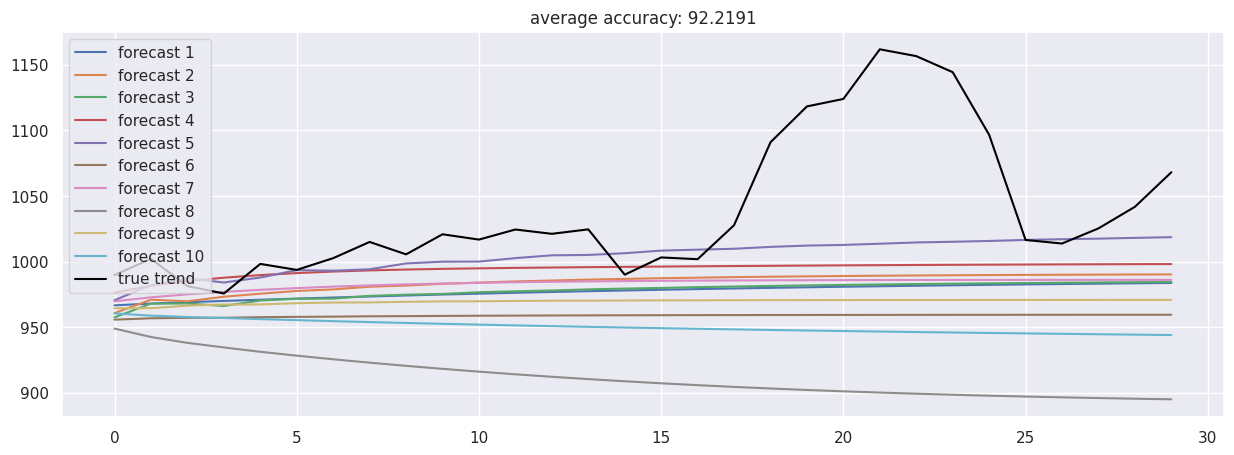

In [14]:
results = []
for i in range(simulation_size):
    print('simulation %d' % (i + 1))
    results.append(forecast())

accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average accuracy: %.4f' % (np.mean(accuracies)))
plt.show()